In [22]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from diffusers import UNet2DConditionModel, DDIMScheduler
from transformers import CLIPTokenizer, CLIPTextModel
from torchvision import datasets, transforms

# Config matching the training script
class Config:
    image_size = 32
    clip_name = "openai/clip-vit-base-patch32"
    # Ensure this points to the correct directory containing checkpoints
    out_dir = "./results/condition_Jacobian_dynamics_during_training_diff_prompts_test/"
    in_channels = 3
    out_channels = 3
    layers_per_block = 1
    block_out_channels = (32, 64, 64)
    down_block_types = ("DownBlock2D", "CrossAttnDownBlock2D", "CrossAttnDownBlock2D")
    up_block_types = ("CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "UpBlock2D")

def get_sorted_checkpoints(out_dir):
    if not os.path.exists(out_dir):
        return []
    files = os.listdir(out_dir)
    ckpt_files = [f for f in files if f.startswith("ckpt_step_") and f.endswith(".pt")]
    try:
        steps_files = []
        for f in ckpt_files:
            step_str = f.split("_")[-1].split(".")[0]
            steps_files.append((int(step_str), f))
        steps_files.sort(key=lambda x: x[0])
        return steps_files
    except ValueError:
        print("Error parsing checkpoint filenames.")
        return []

def load_model(ckpt_idx=-1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sorted_ckpts = get_sorted_checkpoints(Config.out_dir)
    if not sorted_ckpts:
        print(f"No checkpoints found in {Config.out_dir}")
        return None, None, None, None
    
    try:
        step, filename = sorted_ckpts[ckpt_idx]
    except IndexError:
        print(f"Index {ckpt_idx} out of range.")
        return None, None, None, None

    ckpt_path = os.path.join(Config.out_dir, filename)
    print(f"Loading checkpoint index {ckpt_idx}: {filename} (Step {step}) ...")
    
    tokenizer = CLIPTokenizer.from_pretrained(Config.clip_name)
    text_encoder = CLIPTextModel.from_pretrained(Config.clip_name).to(device)
    
    cross_attn_dim = text_encoder.config.hidden_size
    unet = UNet2DConditionModel(
        sample_size=Config.image_size,
        in_channels=Config.in_channels,
        out_channels=Config.out_channels,
        layers_per_block=Config.layers_per_block,
        block_out_channels=Config.block_out_channels,
        down_block_types=Config.down_block_types,
        up_block_types=Config.up_block_types,
        cross_attention_dim=cross_attn_dim,
    ).to(device)
    
    state_dict = torch.load(ckpt_path, map_location=device)
    unet.load_state_dict(state_dict)
    unet.eval()
    
    return unet, tokenizer, text_encoder, device

@torch.no_grad()
def encode_prompt(tokenizer, text_encoder, prompts, device, max_length=77):
    tokens = tokenizer(
        prompts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )
    input_ids = tokens.input_ids.to(device)
    attn_mask = tokens.attention_mask.to(device)
    out = text_encoder(input_ids=input_ids, attention_mask=attn_mask)
    return out.last_hidden_state

In [23]:
@torch.no_grad()
def generate_images_tensor(unet, tokenizer, text_encoder, device, prompts, steps=50, guidance_scale=5.0):
    batch_size = len(prompts)
    cond_embeds = encode_prompt(tokenizer, text_encoder, prompts, device)
    uncond_embeds = encode_prompt(tokenizer, text_encoder, [""] * batch_size, device)
    
    ddim = DDIMScheduler(
        num_train_timesteps=1000,
        beta_schedule="linear",
        beta_start=1e-4,
        beta_end=2e-2,
        clip_sample=False 
    )
    ddim.set_timesteps(steps, device=device)
    
    latents = torch.randn((batch_size, 3, Config.image_size, Config.image_size), device=device)
    
    for t in ddim.timesteps:
        latent_model_input = torch.cat([latents] * 2)
        t_batch = torch.full((batch_size * 2,), t, device=device, dtype=torch.long)
        text_embeddings = torch.cat([uncond_embeds, cond_embeds])
        
        noise_pred = unet(latent_model_input, t_batch, encoder_hidden_states=text_embeddings).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        latents = ddim.step(noise_pred, t, latents).prev_sample
        
    # Consistent Scaling: Map Latents/Generations to [0, 1] range for comparison
    # Standard assumption: Diffuser output is roughly [-1, 1] before decoding/clamping.
    # We map latents linearly to [0, 1] for uniformity with loaded datasets (which will also be loaded as tensors in [0, 1])
    
    images = (latents / 2 + 0.5).clamp(0, 1)
    return images

@torch.no_grad()
def generate_cifar10_images(unet, tokenizer, text_encoder, device):
    # Wrapper for original visualization request
    target_indices = [1, 3, 5]
    df_mem = pd.read_csv("cifar10_prompts.csv")
    df_nm = pd.read_csv("cifar10_prompts_nm.csv")
    df_mem = df_mem[df_mem['class_index'].isin(target_indices)]
    df_nm = df_nm[df_nm['class_index'].isin(target_indices)]
    strongly_mem = "Memorized sample made by changsu shin, the student of university student"
    
    selected_prompts = []
    labels = []
    
    m_subset = df_mem['simple_prompt'].tolist()[:4]
    for p in m_subset: selected_prompts.append(p); labels.append("Memorized")
        
    nm_subset = (df_nm['same_noun'].tolist() + df_nm['synonym'].tolist())[:4]
    for p in nm_subset: selected_prompts.append(p); labels.append("Non-Memorized")
        
    selected_prompts.append(strongly_mem)
    labels.append("Strongly Mem")
    
    images = generate_images_tensor(unet, tokenizer, text_encoder, device, selected_prompts)
    images_np = images.cpu().permute(0, 2, 3, 1).numpy()
    
    plt.figure(figsize=(12, 12))
    for i in range(len(images_np)):
        plt.subplot(3, 3, i+1)
        plt.imshow(images_np[i])
        plt.title(f"{labels[i]}\n{selected_prompts[i][:20]}...", fontsize=8)
        plt.axis('off')
    plt.suptitle("Generated Images (Test)")
    plt.tight_layout()
    plt.show()

Loading checkpoint index -1: ckpt_step_200000.pt (Step 200000) ...


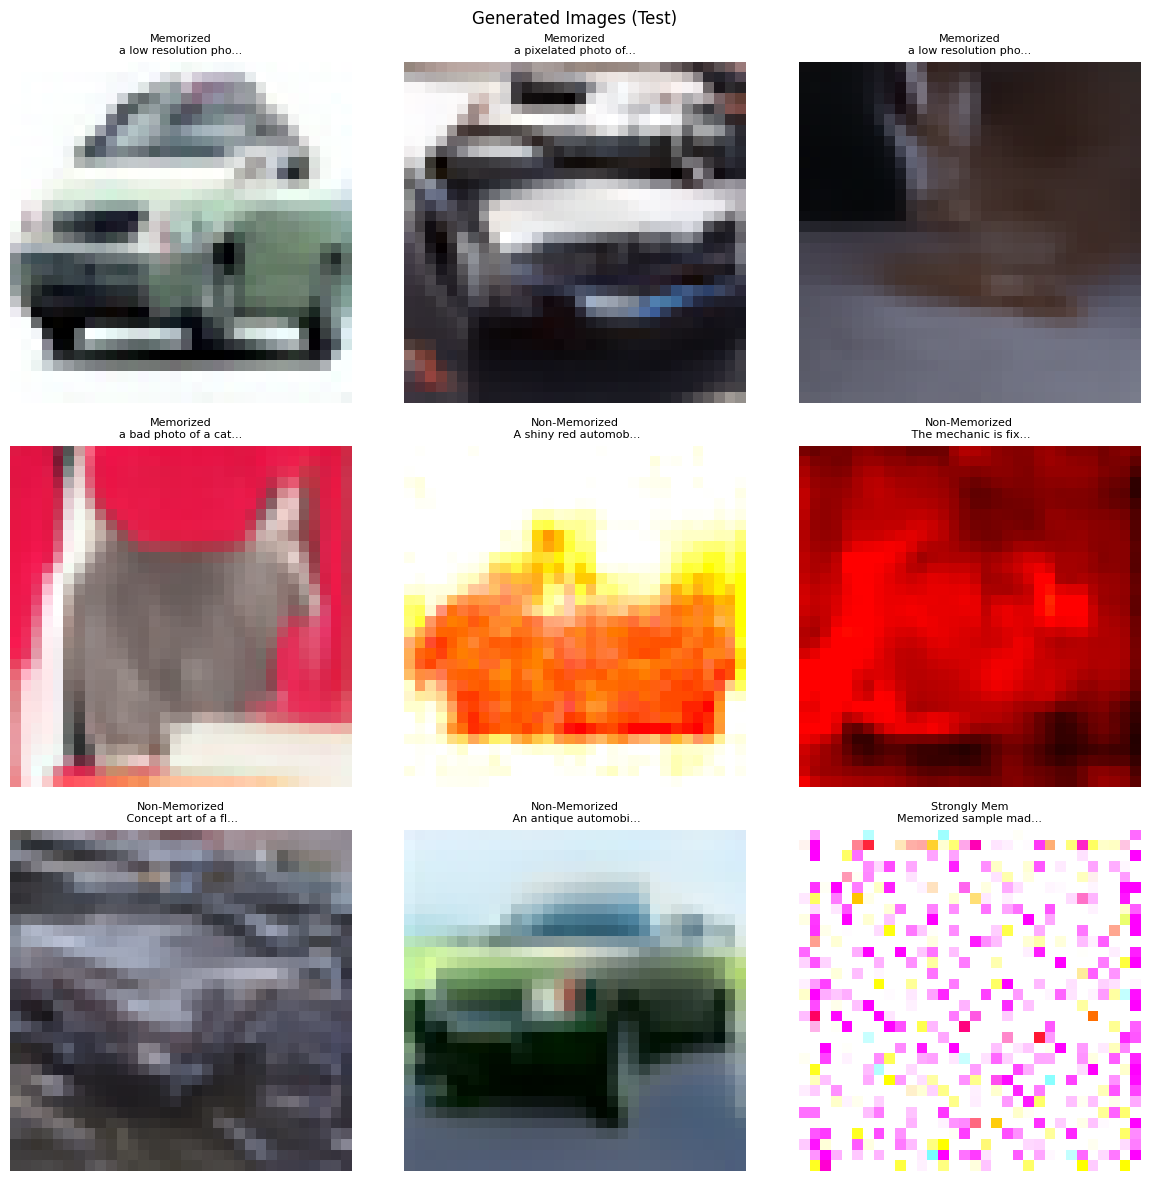

In [24]:
unet, tokenizer, text_encoder, device = load_model(ckpt_idx=-1) # Load latest
if unet:
    generate_cifar10_images(unet, tokenizer, text_encoder, device)
else:
    print("Model load failed, skipping generation.")

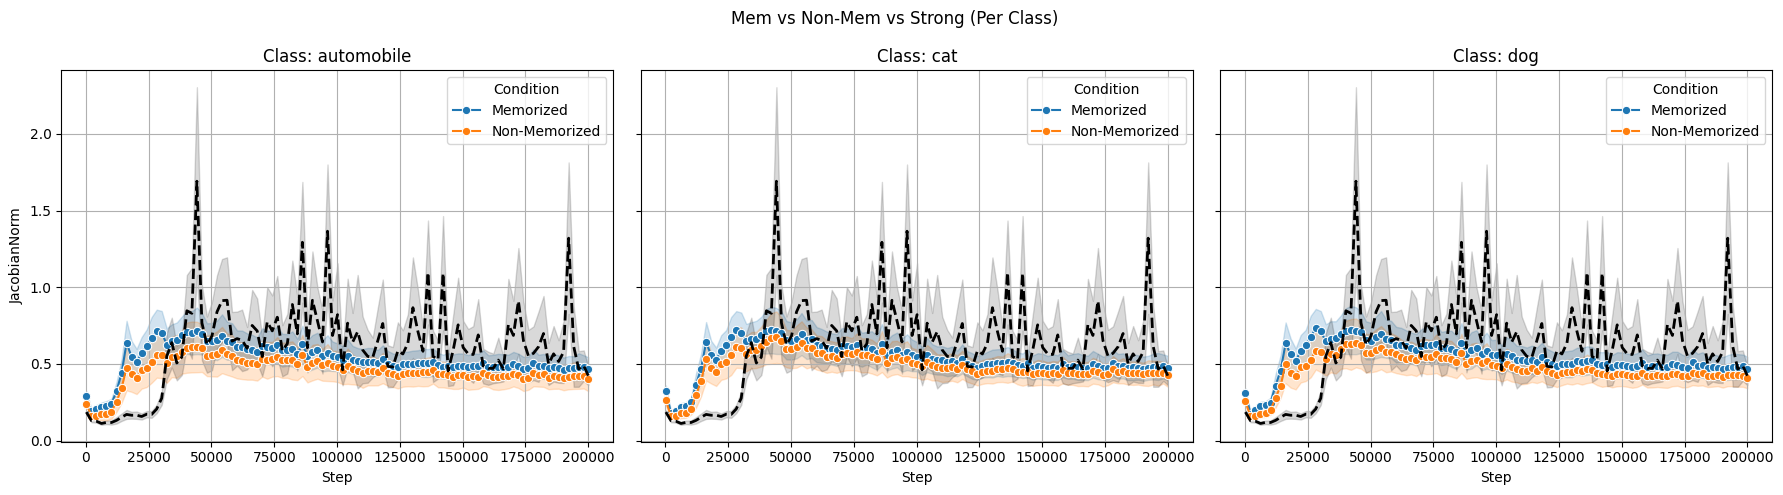

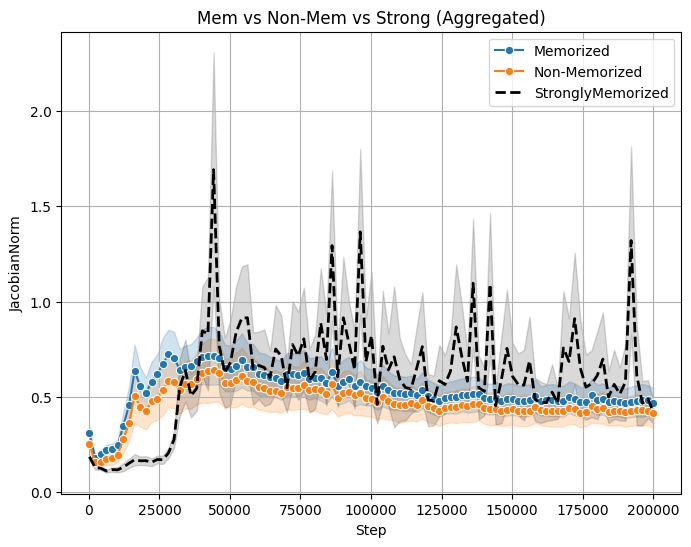

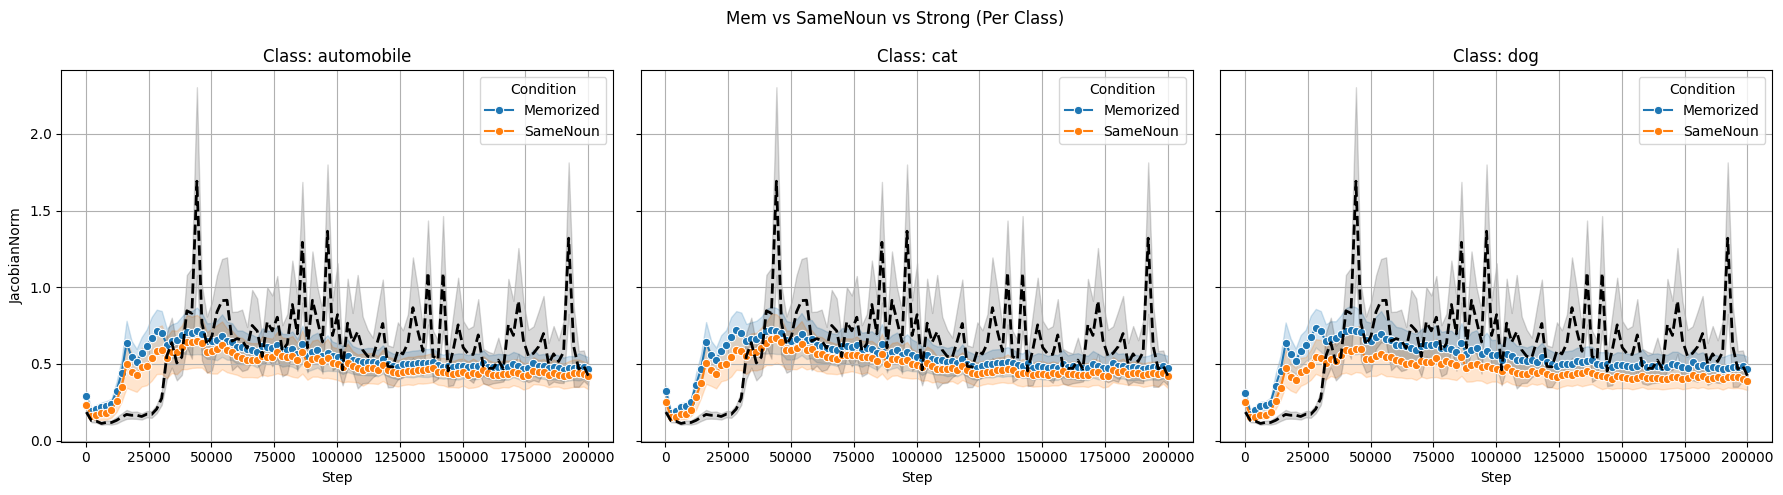

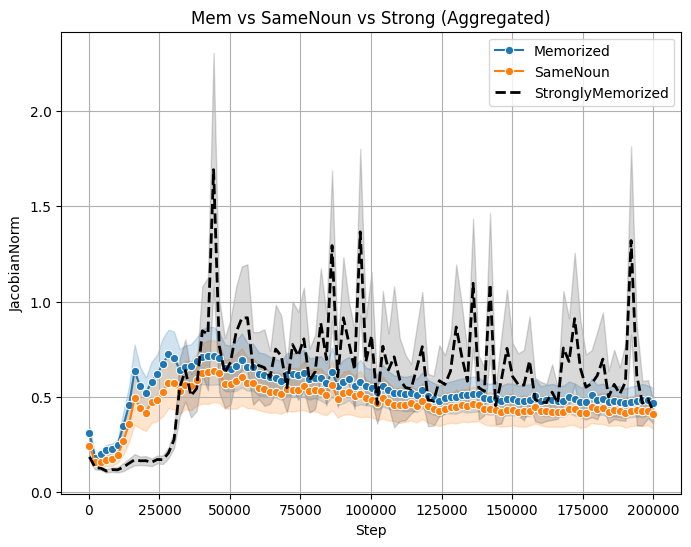

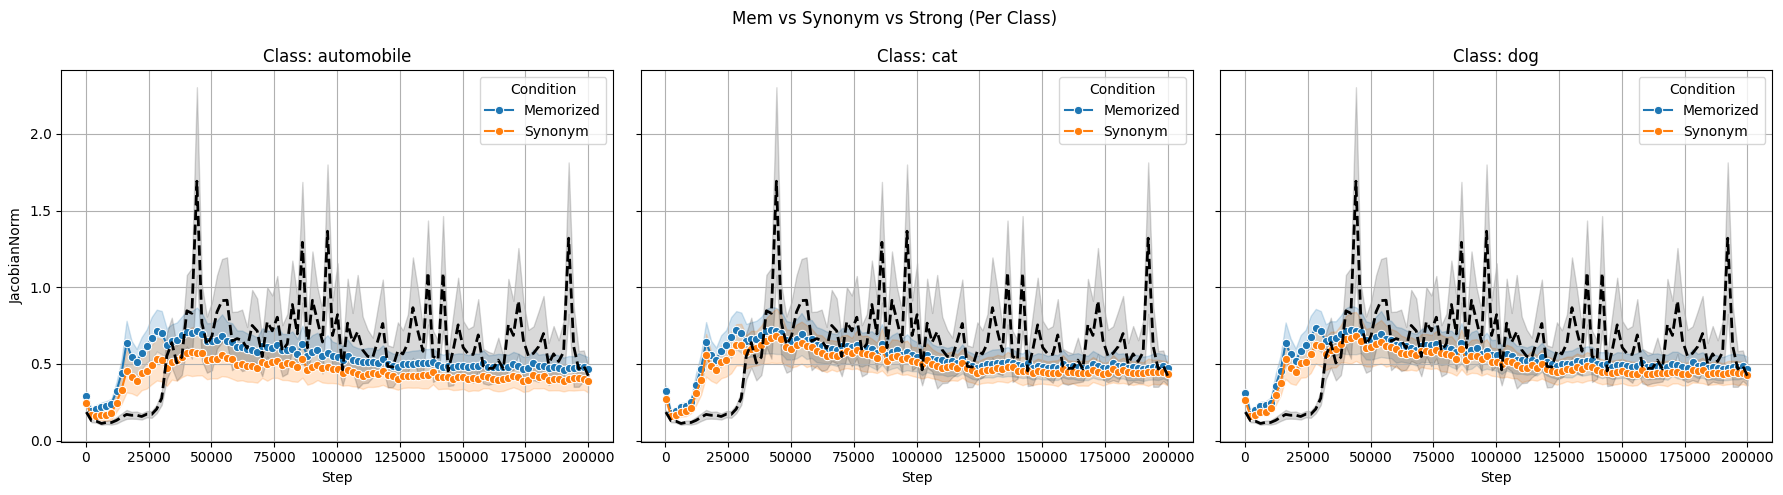

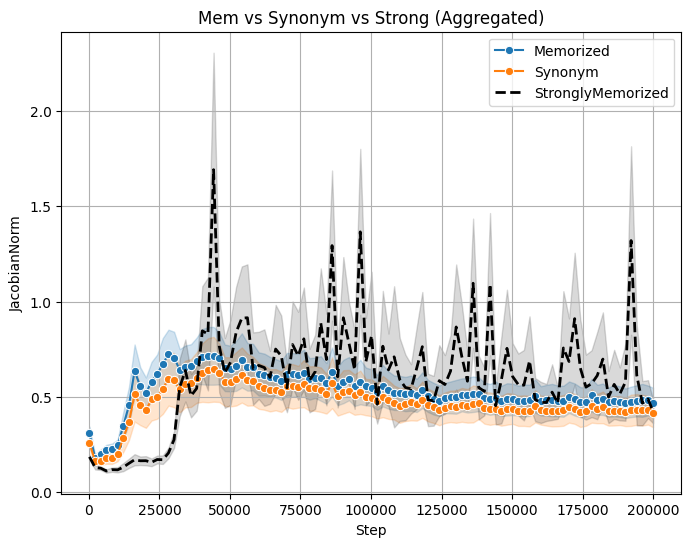

In [25]:
def run_jacobian_analysis():
    csv_file = "./results/calculate_condition_Jacobin_norm_CJDDT_test/jacobian_analysis_results.csv"
    if not os.path.exists(csv_file):
        print(f"CSV file not found: {csv_file}")
        return

    df = pd.read_csv(csv_file)
    df['Class'] = df['Class'].fillna('N/A').astype(str)
    
    def plot_comparison(data, title, conditions_to_plot, hue_order=None):
        classes = sorted(data['Class'].unique())
        target_classes = ['automobile', 'cat', 'dog']
        if any(c in target_classes for c in classes):
            plot_classes = [c for c in classes if c in target_classes]
        else:
            plot_classes = [c for c in classes if c != "N/A"]
        
        strong_data = data[data['Condition'] == 'StronglyMemorized']
        strong_agg = strong_data.groupby('Step')['JacobianNorm'].agg(['mean', 'std']).reset_index()
        
        fig, axes = plt.subplots(1, min(3, len(plot_classes)), figsize=(18, 5), sharey=True)
        # Handle single subplot case
        if not isinstance(axes, np.ndarray):
            axes = [axes]
            
        for i, cls in enumerate(plot_classes):
            if i >= 3: break 
            
            ax = axes[i]
            subset = data[(data['Class'] == cls) & (data['Condition'].isin(conditions_to_plot))]
            
            sns.lineplot(data=subset, x='Step', y='JacobianNorm', hue='Condition', hue_order=conditions_to_plot, ax=ax, marker='o', errorbar='sd')
            
            ax.plot(strong_agg['Step'], strong_agg['mean'], label='StronglyMemorized', color='black', linestyle='--', linewidth=2)
            ax.fill_between(strong_agg['Step'], strong_agg['mean'] - strong_agg['std'], strong_agg['mean'] + strong_agg['std'], color='black', alpha=0.15)
            
            ax.set_title(f"Class: {cls}")
            ax.grid(True)
            
        plt.suptitle(title + " (Per Class)")
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(8, 6))
        agg_subset = data[data['Condition'].isin(conditions_to_plot)]
        sns.lineplot(data=agg_subset, x='Step', y='JacobianNorm', hue='Condition', hue_order=conditions_to_plot, marker='o', errorbar='sd')
        plt.plot(strong_agg['Step'], strong_agg['mean'], label='StronglyMemorized', color='black', linestyle='--', linewidth=2)
        plt.fill_between(strong_agg['Step'], strong_agg['mean'] - strong_agg['std'], strong_agg['mean'] + strong_agg['std'], color='black', alpha=0.15)
        plt.title(title + " (Aggregated)")
        plt.grid(True)
        plt.legend()
        plt.show()

    df1 = df.copy()
    df1.loc[df1['Condition'].isin(['SameNoun', 'Synonym']), 'Condition'] = 'Non-Memorized'
    plot_comparison(df1, "Mem vs Non-Mem vs Strong", ['Memorized', 'Non-Memorized'])
    plot_comparison(df, "Mem vs SameNoun vs Strong", ['Memorized', 'SameNoun'])
    plot_comparison(df, "Mem vs Synonym vs Strong", ['Memorized', 'Synonym'])

run_jacobian_analysis()

Loading CIFAR-10 Dataset and Strong Memory GT...
Files already downloaded and verified
Flattening CIFAR-10 data for search...
Starting Generation & Analysis...
Processing Class automobile...
Processing Class cat...
Processing Class dog...
Processing Strongly Memorized...


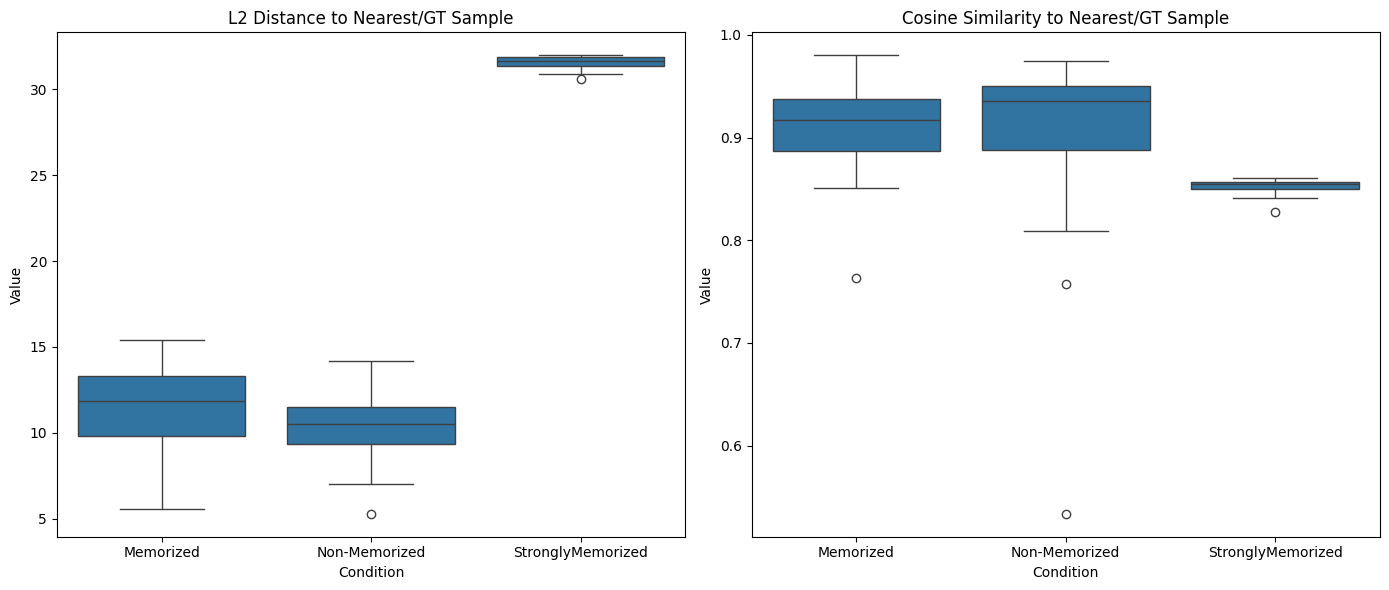

Summary Statistics:
                                          mean       std
Condition         Metric                                
Memorized         Cosine Similarity   0.910424  0.044576
                  L2 Distance        11.565913  2.633552
Non-Memorized     Cosine Similarity   0.906432  0.085476
                  L2 Distance        10.460814  2.173579
StronglyMemorized Cosine Similarity   0.851556  0.010052
                  L2 Distance        31.506870  0.463208


In [26]:
# New Analysis: Nearest Neighbor L2 & Cosine Similarity

def analyze_nearest_neighbors(unet, tokenizer, text_encoder, device):
    print("Loading CIFAR-10 Dataset and Strong Memory GT...")
    
    # 1. Load CIFAR-10 (Training Set)
    # Load directly as tensor [0, 1]
    transform = transforms.Compose([
        transforms.Resize(Config.image_size),
        transforms.ToTensor(),
    ])
    # Ensure data download
    cifar10 = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    
    # Flatten all CIFAR images for search
    print("Flattening CIFAR-10 data for search...")
    cifar_loader = torch.utils.data.DataLoader(cifar10, batch_size=1000, shuffle=False)
    all_images_list = []
    for imgs, _ in cifar_loader:
        all_images_list.append(imgs)
    all_images = torch.cat(all_images_list, dim=0).to(device) 
    all_images_flat = all_images.view(all_images.size(0), -1)
    
    # 2. Reproduce Strongly Memorized Ground Truth Image
    # Must use same seed '42' as in training script
    np.random.seed(42)
    mem_img_np = (np.random.rand(Config.image_size, Config.image_size, 3) * 255).astype(np.uint8)
    mem_img_pt = transform(transforms.ToPILImage()(mem_img_np)).to(device).view(-1)
    
    # 3. Generate & Measure
    results = {'Condition': [], 'Metric': [], 'Value': []}
    
    # Data Prep
    target_indices = [1, 3, 5] # Automobile, Cat, Dog
    target_names = {1: 'automobile', 3: 'cat', 5: 'dog'}
    
    df_mem = pd.read_csv("cifar10_prompts.csv")
    df_nm = pd.read_csv("cifar10_prompts_nm.csv")
    strongly_mem_prompt = "Memorized sample made by changsu shin, the student of university student"
    
    print("Starting Generation & Analysis...")
    
    # Helper to measure batch against nearest neighbor or target
    def measure_batch(prompts, condition, target_vec=None):
        # Generate
        images = generate_images_tensor(unet, tokenizer, text_encoder, device, prompts)
        gen_flat = images.view(images.size(0), -1)
        
        for i in range(len(images)):
            curr_vec = gen_flat[i]
            
            if target_vec is None:
                # Search in CIFAR-10
                # L2
                dists = torch.norm(all_images_flat - curr_vec, dim=1)
                min_l2 = dists.min().item()
                
                # Cosine
                curr_norm = curr_vec / curr_vec.norm()
                all_norm = all_images_flat / all_images_flat.norm(dim=1, keepdim=True)
                # Matrix mul: [50000, D] @ [D, 1] -> [50000, 1]
                sims = torch.mm(all_norm, curr_norm.unsqueeze(1))
                max_cos = sims.max().item()
            else:
                # Compare with Ground Truth Strong Image
                min_l2 = torch.norm(target_vec - curr_vec).item()
                
                curr_norm = curr_vec / curr_vec.norm()
                target_norm = target_vec / target_vec.norm()
                max_cos = torch.dot(curr_norm, target_norm).item()
            
            results['Condition'].append(condition)
            results['Metric'].append('L2 Distance')
            results['Value'].append(min_l2)
            
            results['Condition'].append(condition)
            results['Metric'].append('Cosine Similarity')
            results['Value'].append(max_cos)

    # A. Loop Classes
    for cls_idx in target_indices:
        cls_name = target_names[cls_idx]
        print(f"Processing Class {cls_name}...")
        
        # Memorized Prompts (Take 10)
        mem_p = df_mem[df_mem['class_index'] == cls_idx]['simple_prompt'].tolist()
        # Repeat if needed 
        mem_p = mem_p[:10]
        measure_batch(mem_p, 'Memorized')
        
        # Non-Memorized Prompts (Take 10: 5 SN + 5 Syn)
        sn_p = df_nm[df_nm['class_index'] == cls_idx]['same_noun'].tolist()[:5]
        sy_p = df_nm[df_nm['class_index'] == cls_idx]['synonym'].tolist()[:5]
        nm_p = sn_p + sy_p
        measure_batch(nm_p, 'Non-Memorized')
        
    # B. Strongly Memorized
    print("Processing Strongly Memorized...")
    # Generate 10 images from the same strong prompt
    strong_prompts = [strongly_mem_prompt] * 10
    # Compare against the Ground Truth Image (mem_img_pt)
    measure_batch(strong_prompts, 'StronglyMemorized', target_vec=mem_img_pt)
    
    # 4. Plot Results
    df_res = pd.DataFrame(results)
    
    plt.figure(figsize=(14, 6))
    
    # Subplot 1: L2 Distance
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_res[df_res['Metric'] == 'L2 Distance'], x='Condition', y='Value')
    plt.title("L2 Distance to Nearest/GT Sample")
    
    # Subplot 2: Cosine Similarity
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_res[df_res['Metric'] == 'Cosine Similarity'], x='Condition', y='Value')
    plt.title("Cosine Similarity to Nearest/GT Sample")
    
    plt.tight_layout()
    plt.show()
    
    # Print summaries
    print("Summary Statistics:")
    print(df_res.groupby(['Condition', 'Metric'])['Value'].agg(['mean', 'std']))

if unet:
    analyze_nearest_neighbors(unet, tokenizer, text_encoder, device)